In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import sys
import msgpack as mp
import msgpack_numpy as mpn
sys.path.append(os.path.join(os.getcwd(), ".."))
from support.generate_ar_data import *
from support.pd_support import *
from support.calculations_support import *
from support.mecanum_calculations import *
from support.ar_calculations import *
import pandas as pd
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from tqdm import tqdm
import keyboard
import time
from IPython.display import display, clear_output
import seaborn as sns


In [2]:
_parent_folder = "multi_cam_nov_14"
_base_pth = os.path.dirname(os.getcwd())
_base_pth = os.path.join(_base_pth, "recording_programs", "test_data", _parent_folder)
_base_pth

'c:\\Users\\CMC\\Documents\\openposelibs\\pose\\armbo\\recording_programs\\test_data\\multi_cam_nov_14'

In [3]:
""" read excel sheet"""
folder_df = pd.read_excel(os.path.join(_base_pth, "00_analysis", "calibration_files_corrected.xlsx"))
_analysis_pth = os.path.join(_base_pth, "00_analysis")
folder_df

,folder_name,calibration_folder,flip
0,sk16_15_forward_fast,calibration_15fps_sk,False
1,sk16_15_forward_fast_2,calibration_15fps_sk,False
2,sk16_15_forward_medium,calibration_15fps_sk,False
3,sk16_15_forward_medium_2,calibration_15fps_sk,False
4,sk16_15_forward_slow,calibration_15fps_sk,False
...,...,...,...
84,sk16_60_sideways_fast_2,calibration_60fps_quad_sk_3,False
85,sk16_60_sideways_medium,calibration_60fps_quad_sk_3,False
86,sk16_60_sideways_medium_2,calibration_60fps_quad_sk_3,False
87,sk16_60_sideways_slow,calibration_60fps_quad_sk_3,False


In [16]:
mean_err_df = pd.DataFrame(columns=["folder_name","frame_id","err_x", "err_y", "err_z",
                                     "max_err_x", "max_err_y", "max_err_z",
                                     "std_err_x", "std_err_y", "std_err_z"])

In [17]:
for idx, _folder_name in enumerate(tqdm(folder_df.folder_name)):
    # print(idx)
    _phone_cam_folder = os.path.join(_analysis_pth, "coordinates_webcam_wot_2", _folder_name + ".csv")
    _mc_folder = os.path.join(_analysis_pth, "coordinates_mc_2", _folder_name + ".csv")

    _phone_cam_df = pd.read_csv(_phone_cam_folder)
    _m_df = pd.read_csv(_mc_folder)

    #read the calibration file
    _webcam_calib_folder = folder_df.calibration_folder[idx]
    _webcam_calib_folder = os.path.join(_base_pth, _webcam_calib_folder)

    with open(os.path.join(_webcam_calib_folder, "webcam_rotmat.msgpack"), "rb") as f:
        webcam_rotmat = mp.Unpacker(f, object_hook=mpn.decode)
        _webcam_rot = next(webcam_rotmat)
        _webcam_org = next(webcam_rotmat)
    
    # angle calculation for phone cam
    _w_df = _phone_cam_df.copy()

    # applying filter
    _w_df.yaw = savgol_filter(_w_df.yaw, 51, 1)
    _w_df.pitch = savgol_filter(_w_df.pitch, 51, 1)
    _w_df.roll = savgol_filter(_w_df.roll, 51, 1)

    """calculating angle from aruco marker"""
    # getting rotation matrix from yaw, pitch, roll
    _ar_rotmat_i = []
    for i in range(len(_w_df)):
        
        _val = _w_df[["yaw", "pitch", "roll"]].loc[i].values
        _val = np.reshape(_val, (3,1))
        _ar_rotmat_i.append(cv2.Rodrigues(_val))
    
    # calculating del r for aruco marker
    _del_ar_r = []
    _rotmat_la_0 = _webcam_rot.T @ _ar_rotmat_i[0][0]
    for i in range(len(_ar_rotmat_i)):
        _rotmat_la = _webcam_rot.T @ _ar_rotmat_i[i][0]
        _del_ar_r.append(_rotmat_la_0.T@_rotmat_la)

    # calculating angle for aruco marker
    _ar_theta_x = []
    _ar_theta_y = []
    _ar_theta_z = []

    for i in _del_ar_r:
        _ar_theta_x.append(np.arctan2(i[2,1], i[2,2]))
        _ar_theta_y.append(np.arctan2(-i[2,0], np.sqrt(i[2,1]**2 + i[2,2]**2)))
        _ar_theta_z.append(np.arctan2(i[1,0], i[0,0]))
    
    _ar_theta_x = np.array(_ar_theta_x)
    _ar_theta_y = np.array(_ar_theta_y)
    _ar_theta_z = np.array(_ar_theta_z)

    # converting them to degrees
    _ar_theta_x = np.rad2deg(_ar_theta_x)
    _ar_theta_y = np.rad2deg(_ar_theta_y)
    _ar_theta_z = np.rad2deg(_ar_theta_z)

    # angle calculation for mc
    """
    axis definition

    _xvec = bottom right
    org = bottom left
    _yvec = top left
    """

    _rotmat_i = []
    for i in range(len(_m_df)):
        
        _x_vec = _m_df[["rb_x", "rb_y", "rb_z"]].loc[i].values
        _x_vec = np.reshape(_x_vec, (3,1))
        _org = _m_df[["lb_x", "lb_y", "lb_z"]].loc[i].values
        _org = np.reshape(_org, (3,1))
        _y_vec = _m_df[["lt_x", "lt_y", "lt_z"]].loc[i].values
        _y_vec = np.reshape(_y_vec, (3,1))
        _rotmat_i.append(calculate_rotmat_from_xyo(_x_vec, _y_vec, _org))

    # calculating del rotmat for mc
    _del_r = []
    for i in range(len(_rotmat_i)):
        _del_r.append(_rotmat_i[i].T@_rotmat_i[0])

    # calculating angle for mc

    _theta_x = []
    _theta_y = []
    _theta_z = []

    for i in _del_r:
        _theta_x.append(np.arctan2(i[2,1], i[2,2]))
        _theta_y.append(np.arctan2(-i[2,0], np.sqrt(i[2,1]**2 + i[2,2]**2)))
        _theta_z.append(np.arctan2(i[1,0], i[0,0]))
        
    _theta_x = np.array(_theta_x)
    _theta_y = np.array(_theta_y)
    _theta_z = np.array(_theta_z)

    # converting them to degrees
    _theta_x = np.rad2deg(_theta_x)
    _theta_y = np.rad2deg(_theta_y)
    _theta_z = np.rad2deg(_theta_z)
    
    # calculating error
    _err_x = _theta_x - _ar_theta_x
    _err_y = _theta_y - _ar_theta_y
    _err_z = _theta_z - _ar_theta_z

    # calculating max error
    _max_err_x = np.max(np.abs(_err_x))
    _max_err_y = np.max(np.abs(_err_y))
    _max_err_z = np.max(np.abs(_err_z))

    # calculating mean error
    _mean_err_x = np.mean(np.abs(_err_x))
    _mean_err_y = np.mean(np.abs(_err_y))
    _mean_err_z = np.mean(np.abs(_err_z))

    # calculating std error
    _std_err_x = np.std(_err_x)
    _std_err_y = np.std(_err_y)
    _std_err_z = np.std(_err_z)

    # error df
    mean_err_df = mean_err_df.append({"folder_name": folder_df.folder_name[idx], "frame_id":  _w_df["frame_id"][0],
                                    "err_x": _mean_err_x, "err_y": _mean_err_y, "err_z": _mean_err_z, 
                                    "max_err_x": _max_err_x, "max_err_y": _max_err_y, "max_err_z": _max_err_z, 
                                    "std_err_x": _std_err_x, "std_err_y": _std_err_y, "std_err_z": _std_err_z}, ignore_index=True)

100%|██████████| 89/89 [07:51<00:00,  5.29s/it]


In [13]:
# find fps using filename
fps_values = []
for i in mean_err_df.folder_name:
    _fps = i.split("_")[1]
    _fps = int(_fps)
    fps_values.append(_fps)
mean_err_df["fps"] = fps_values

# find speed of movement
speed_values = []
for i in mean_err_df.folder_name:
    _speed = i.split("_")[3]
    speed_values.append(_speed)
mean_err_df["speed"] = speed_values

In [14]:
_mean_df_pth = os.path.join(_analysis_pth, "mean_error_df_angle_filter.csv")
mean_err_df.to_csv(_mean_df_pth, index=False)
mean_err_df

,folder_name,frame_id,err_x,err_y,err_z,max_err_x,max_err_y,max_err_z,std_err_x,std_err_y,std_err_z,fps,speed
0,sk16_15_forward_fast,5.0,0.788525,0.106587,0.052658,3.135638,0.277692,0.149398,0.905995,0.038937,0.021963,15,fast
1,sk16_15_forward_fast_2,5.0,0.632035,0.019241,0.016338,3.141046,0.073841,0.119931,0.726277,0.023596,0.018708,15,fast
2,sk16_15_forward_medium,5.0,1.288962,0.074325,0.033206,3.138391,0.144407,0.113480,1.070886,0.033412,0.026383,15,medium
3,sk16_15_forward_medium_2,5.0,0.584937,0.027927,0.010227,2.920905,0.094629,0.069506,0.764503,0.035043,0.014286,15,medium
4,sk16_15_forward_slow,5.0,0.590007,0.020516,0.007836,3.119529,0.084343,0.054449,0.803276,0.022010,0.011262,15,slow
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,sk16_60_sideways_fast_2,5.0,88.733931,2.957163,3.575989,180.256310,19.115438,19.016702,87.122709,4.375011,4.897793,60,fast
174,sk16_60_sideways_medium,5.0,73.188805,2.603798,2.877305,180.663011,12.286991,17.985094,76.593542,3.444944,4.161519,60,medium
175,sk16_60_sideways_medium_2,5.0,70.498751,3.012608,3.593181,179.789738,12.004944,16.354331,70.988100,3.430179,3.655125,60,medium
176,sk16_60_sideways_slow,5.0,76.018995,1.991998,4.411292,180.072220,12.919468,16.016028,74.505978,2.648278,3.553728,60,slow


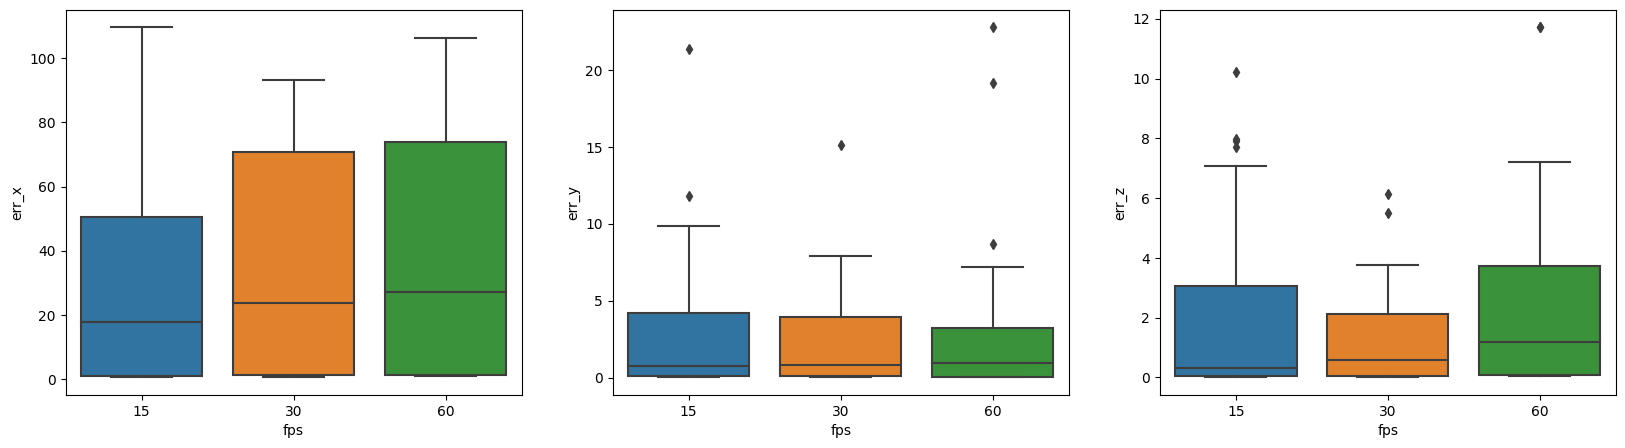

In [15]:
# box plot
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.boxplot(x="fps", y="err_x", data=mean_err_df, ax=ax[0])
sns.boxplot(x="fps", y="err_y", data=mean_err_df, ax=ax[1])
sns.boxplot(x="fps", y="err_z", data=mean_err_df, ax=ax[2])
plt.show()